In [1]:
import torch, random, sys

import tonic
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

from sinabs.activation.surrogate_gradient_fn import PeriodicExponential

import matplotlib.pyplot as plt
import numpy as np

sys.path.append('../../utils')
sys.path.append('../models')

from train_test_fn import training_loop, load_dataset, split_train_validation, load_architecture
from weight_initialization import rescale_method_1

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('device: ', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')

device:  NVIDIA GeForce RTX 3070 Ti


In [3]:
rand_seed = 1

In [4]:
achitecture = 'ResSCNN1'

In [5]:
torch.backends.cudnn.enabled = False
torch.backends.cudnn.deterministic = True
random.seed(rand_seed)
torch.manual_seed(rand_seed)
torch.cuda.manual_seed(rand_seed)
np.random.seed(rand_seed)

In [6]:
batch_size = 8
num_workers = 4
epochs = 30
lr = 5e-5

spk_thr = 2.0
v_min = -0.313

grad_scale = 1.534
grad_width = 0.759

validation_ratio = 0.2
n_time_steps = 50

## Loading Data

In [7]:
snn_train_dataset, snn_test_dataset, sensor_size = load_dataset('DVSGESTURE', n_time_steps)

getting validation dataset....

In [8]:
train_dataset, validation_dataset = split_train_validation(validation_ratio, snn_train_dataset, rand_seed)

In [9]:
sample_data, label = train_dataset[0]
print(f"The transformed array is in shape [Time-Step, Channel, Height, Width] --> {sample_data.shape}")

The transformed array is in shape [Time-Step, Channel, Height, Width] --> (50, 2, 128, 128)


disk caching samples...

In [10]:
disk_cache_train = tonic.DiskCachedDataset(
    dataset=train_dataset,
    cache_path='./cached_train'
)
snn_train_dataloader = DataLoader(disk_cache_train, batch_size=batch_size, num_workers=num_workers, drop_last=True, shuffle=True)

disk_cache_validation = tonic.DiskCachedDataset(
    dataset=validation_dataset,
    cache_path='./cached_validation'
)
snn_validation_dataloader = DataLoader(disk_cache_validation, batch_size=batch_size, num_workers=num_workers, drop_last=True, shuffle=True)

disk_cache_test = tonic.DiskCachedDataset(
    dataset=snn_test_dataset,
    cache_path='./cached_test'
)
snn_test_dataloader = DataLoader(disk_cache_test, batch_size=batch_size, num_workers=num_workers, drop_last=True, shuffle=False)

## Network Module

In [11]:
snn = load_architecture(achitecture, sensor_size, 11, batch_size, PeriodicExponential(grad_scale=grad_scale, grad_width=grad_width), v_min, spk_thr).to(device)
snn.init_weights()

In [12]:
lambda_ = 0.8
snn.rescale_conv_weights(rescale_method_1, lambda_)

recaling factor: 3.2 (computed using 1 kernels and lambda 0.8)
recaling factor: 8.0 (computed using 2 kernels and lambda 0.8)
recaling factor: 3.2 (computed using 1 kernels and lambda 0.8)


In [13]:
optimizer = Adam(snn.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8)
loss_fn = CrossEntropyLoss()

## Training loop

In [14]:
epochs_x, epochs_y, epochs_acc = training_loop(
    device, 
    n_time_steps,
    batch_size,
    sensor_size,
    snn_train_dataloader, 
    snn, 
    loss_fn, 
    optimizer, 
    epochs, 
    snn_validation_dataloader)

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 0 accuracy: 12.5


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 1 accuracy: 10.576923076923077


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 2 accuracy: 10.576923076923077


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 3 accuracy: 9.615384615384617


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 4 accuracy: 12.980769230769232


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 5 accuracy: 12.01923076923077


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 6 accuracy: 12.980769230769232


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 7 accuracy: 12.5


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 8 accuracy: 11.057692307692307


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 9 accuracy: 12.980769230769232


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 10 accuracy: 10.096153846153847


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 11 accuracy: 9.615384615384617


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 12 accuracy: 9.615384615384617


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 13 accuracy: 12.5


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 14 accuracy: 9.615384615384617


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 15 accuracy: 10.096153846153847


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 16 accuracy: 10.576923076923077


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 17 accuracy: 11.057692307692307


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 18 accuracy: 12.5


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 19 accuracy: 9.615384615384617


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 20 accuracy: 10.096153846153847


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 21 accuracy: 10.096153846153847


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 22 accuracy: 10.096153846153847


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 23 accuracy: 10.096153846153847


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 24 accuracy: 12.5


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 25 accuracy: 9.134615384615383


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 26 accuracy: 11.057692307692307


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 27 accuracy: 9.615384615384617


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 28 accuracy: 12.01923076923077


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 29 accuracy: 10.096153846153847


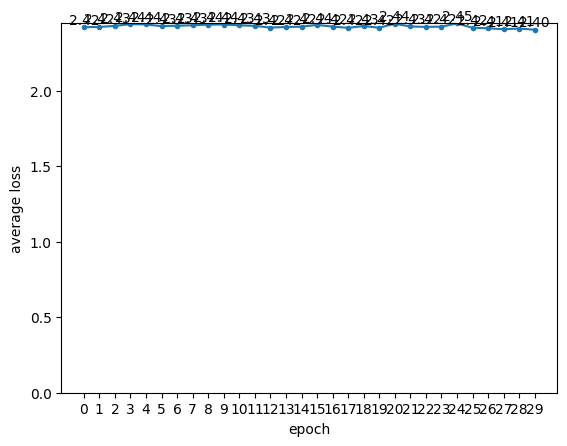

In [15]:
y_avg = []
for y in epochs_y:
    y_avg.append(np.mean(y))

plt.plot(np.arange(len(epochs_x)), y_avg, marker = '.')
plt.xlabel('epoch')
plt.ylabel('average loss')
plt.ylim(0,)
plt.xticks(np.arange(len(epochs_x)))
for i, txt in enumerate(y_avg):
    plt.text(i, txt, f'{txt:.2f}', ha='center', va='bottom', color = 'k')
plt.show()

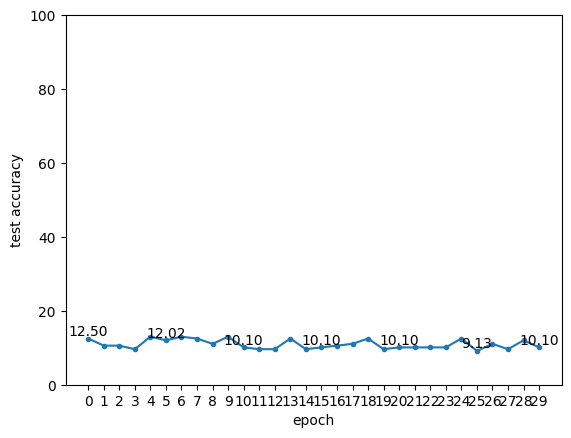

In [16]:
plt.plot(np.arange(len(epochs_x)), epochs_acc, marker = '.')
plt.xlabel('epoch')
plt.ylabel('test accuracy')
plt.ylim(0, 100)
plt.xticks(np.arange(len(epochs_x)))
for i, txt in enumerate(epochs_acc):
    if i%5 ==0 or i == epochs-1:
        plt.text(i, txt, f'{txt:.2f}', ha='center', va='bottom', color = 'k')
plt.show()

In [17]:
# with open(f'./architectures_results/{achitecture}-Training_Validation-TM.npy', 'wb') as f:
#     np.save(f, np.array(epochs_x))
#     np.save(f, np.array(epochs_y))
#     np.save(f, np.array(epochs_acc))